In [1]:
#Load all the libraraies

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cv2 
import itertools
from glob import glob
from PIL import Image

# sklearn and keras model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras.layers import Dense, Dropout, InputLayer, Conv2D, MaxPool2D, Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras.applications.inception_resnet_v2 import InceptionResNetV2




# GLOBAL VARIABLES
scale = 70 # pixal to scale
seed = 7 #fixing random

In [24]:
#Load the data set

In [113]:
#named the species of plant in list
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

In [114]:
# comfirm all png
import glob
picture_num = []
for i in range(12):
    image = glob.glob('/Users/patrick/Desktop/2021S2/BDAP/plant-seedlings-classification/train/' 
                  + species_list[i] + '/*.png')
    picture_num += [len(image)]
picture_num

[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

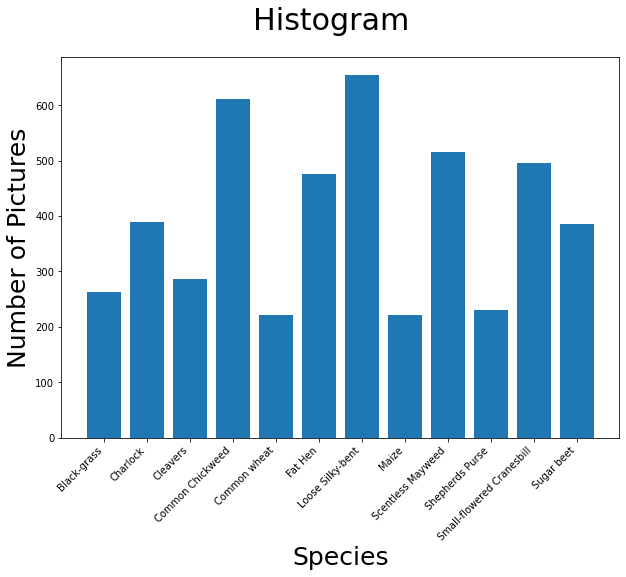

In [115]:
fig = plt.figure(figsize = (10,7)) 
ax = fig.add_subplot(111) # "111" means "1x1 grid, first subplot" 
ax.bar(species_list,picture_num) 
plt.xticks(rotation = 45, ha='right') 
fig.suptitle('Histogram',fontsize=30) 
ax.set_xlabel("Species",fontsize = 25) 
ax.set_ylabel("Number of Pictures",fontsize = 25) 
plt.show()

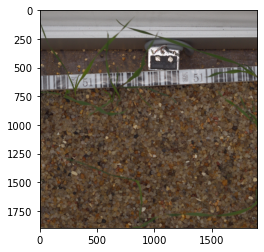

In [116]:
#comfirm that we can show the image from folder

output_sample = np.array(Image.open('/Users/patrick/Desktop/2021S2/BDAP/plant-seedlings-classification/train/Black-grass/0ace21089.png'))

plt.imshow(output_sample)

In [117]:
#data pre-processing
#load the data and resize the images
path_to_image = '/Users/patrick/Desktop/2021S2/BDAP/plant-seedlings-classification/train/*/*.png'
images = glob.glob(path_to_image)
train_image = []
train_label = []
num = len(images)
count = 1
#read images and resize 
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    train_image.append(cv2.resize(cv2.imread(i),(scale,scale)))
    train_label.append(i.split('/')[-2])
    count=count+1
train_image = np.asarray(train_image)
train_label = pd.DataFrame(train_label)

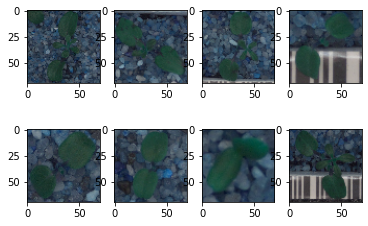

In [135]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train_image[i])

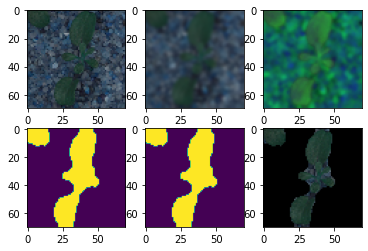

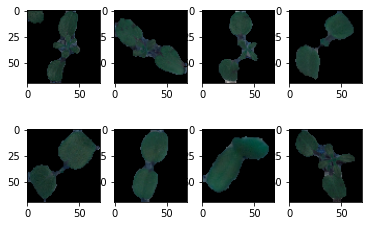

In [118]:
#clean the image and background noisy
new_train_dataset = []
ex = True
for i in train_image:
    # Use gaussian blur
    blurr = cv2.GaussianBlur(i,(5,5),0)
    
    # HSV Converted
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) 
    
    #Green parameters
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper) # Masked
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    
    #create boolean mask
    boolean = mask > 0
    new = np.zeros_like(i,np.uint8)
    
    #apply boolean mask to original image
    new[boolean] = i[boolean]
    
    #append image without background
    new_train_dataset.append(new)
    
    if ex:
        plt.subplot(2,3,1);plt.imshow(i) # Original
        plt.subplot(2,3,2);plt.imshow(blurr) # Blurred
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV Converted
        plt.subplot(2,3,4);plt.imshow(mask) # Masked
        plt.subplot(2,3,5);plt.imshow(boolean) # Boolean masked
        plt.subplot(2,3,6);plt.imshow(new) # New processed image
        plt.show()
        ex = False
new_train_dataset = np.asarray(new_train_dataset)

# Clear images
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train_dataset[i])
        

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


<AxesSubplot:ylabel='0'>

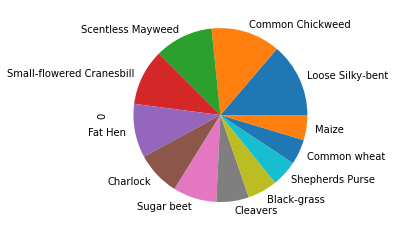

In [120]:
labels = preprocessing.LabelEncoder()
labels.fit(train_label[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(train_label[0])
clear_train_labels = np_utils.to_categorical(encodedlabels)
classes = clear_train_labels.shape[1]
print(str(classes))
train_label[0].value_counts().plot(kind='pie')

In [121]:
#data normalization
new_train_dataset = new_train_dataset/255

In [122]:
#data split
x_train,x_test,y_train,y_test = train_test_split(
    new_train_dataset,
    clear_train_labels,
    test_size=0.1,
    random_state=seed,
    stratify=clear_train_labels)

In [123]:
image_size = 256
batch_size = 32

In [124]:
#use ImageDataGenerator from keras to pre-processing training data
#data augmentation
data_generator = ImageDataGenerator(
    rotation_range =180, #angle value 0~180, random rotation range
    #width_shift_range = 0.2, # vertical shift range ratio of total width
    #height_shift_range = 0.2, # horizontal shift range ratio of total width
    #shear_range = 0.2, # random shear range
    #zoom_range = 0.2, # random zoom range
    horizontal_flip = True, # random horizontal
    vertical_flip = True, # random vertical

)

data_generator.fit(x_train)


In [125]:
#build CNN model
model = Sequential()
model.add(Conv2D(filters=64,
                kernel_size=(5,5),
                padding='same',
                input_shape=(scale,scale,3),
                activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
#MaxPooling size = (2,2)
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#drop some neural avoid overfitting
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

#flatten
model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss= 'categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 70, 70, 64)        4864      
_________________________________________________________________
batch_normalization_48 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 66, 66, 64)        102464    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 33, 33, 64)        256       
_________________________________________________________________
dropout_30 (Dropout)         (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 29, 29, 128)      

In [126]:
# You can save the best model to the checkpoint
checkpoint = ModelCheckpoint('plant_classifier.h5', #where to save the model
                             save_best_only=True, 
                             monitor='val_accuracy', 
                             mode='max', 
                             verbose = 1)

In [127]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', 
                             factor=0.5, 
                             patience=5, 
                             verbose=1, 
                             lr=0.0001)

In [128]:
history = model.fit(data_generator.flow(x_train, y_train, batch_size=batch_size),
          epochs=60, # Increase number of epochs if you have sufficient hardware
          validation_data = (x_test,y_test),
          steps_per_epoch= x_train.shape[0] //batch_size,
          callbacks = [annealer,checkpoint],
          verbose = 1
)

Epoch 1/60
133/133 [==============================] - 243s 2s/step - loss: 2.3943 - accuracy: 0.3189 - val_loss: 7.0627 - val_accuracy: 0.1389

Epoch 00001: val_accuracy improved from -inf to 0.13895, saving model to plant_classifier.h5
Epoch 2/60
133/133 [==============================] - 231s 2s/step - loss: 1.7443 - accuracy: 0.4457 - val_loss: 12.9047 - val_accuracy: 0.0821

Epoch 00002: val_accuracy did not improve from 0.13895
Epoch 3/60
133/133 [==============================] - 231s 2s/step - loss: 1.4126 - accuracy: 0.5293 - val_loss: 6.3164 - val_accuracy: 0.0905

Epoch 00003: val_accuracy did not improve from 0.13895
Epoch 4/60
133/133 [==============================] - 226s 2s/step - loss: 1.2393 - accuracy: 0.5923 - val_loss: 3.0725 - val_accuracy: 0.1453

Epoch 00004: val_accuracy improved from 0.13895 to 0.14526, saving model to plant_classifier.h5
Epoch 5/60
133/133 [==============================] - 227s 2s/step - loss: 1.0593 - accuracy: 0.6479 - val_loss: 1.9052 - va

133/133 [==============================] - 252s 2s/step - loss: 0.2513 - accuracy: 0.9071 - val_loss: 0.3854 - val_accuracy: 0.8274

Epoch 00039: val_accuracy did not improve from 0.90737
Epoch 40/60
133/133 [==============================] - 392s 3s/step - loss: 0.2577 - accuracy: 0.9062 - val_loss: 0.3115 - val_accuracy: 0.8842

Epoch 00040: val_accuracy did not improve from 0.90737
Epoch 41/60
133/133 [==============================] - 278s 2s/step - loss: 0.2330 - accuracy: 0.9161 - val_loss: 0.1980 - val_accuracy: 0.9305

Epoch 00041: val_accuracy improved from 0.90737 to 0.93053, saving model to plant_classifier.h5
Epoch 42/60
133/133 [==============================] - 302s 2s/step - loss: 0.2434 - accuracy: 0.9086 - val_loss: 0.2444 - val_accuracy: 0.9200

Epoch 00042: val_accuracy did not improve from 0.93053
Epoch 43/60
133/133 [==============================] - 280s 2s/step - loss: 0.2350 - accuracy: 0.9133 - val_loss: 0.2864 - val_accuracy: 0.9032

Epoch 00043: val_accuracy 

In [129]:
final_model = load_model('/Users/patrick/Desktop/2021S2/BDAP/plant_classifier.h5')
final_loss, final_accuracy = final_model.evaluate(x_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

15/15 [==============================] - 7s 420ms/step - loss: 0.1837 - accuracy: 0.9432
Final Loss: 0.18374565243721008, Final Accuracy: 0.9431579113006592


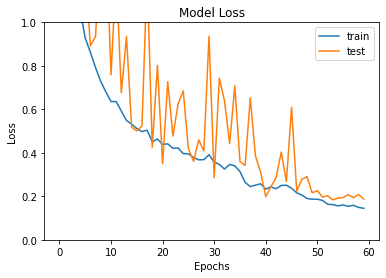

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'])
plt.ylim(0, 1)
plt.show()

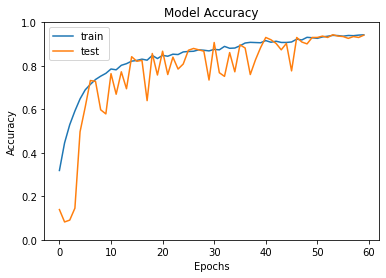

In [131]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'])
plt.ylim(0, 1)
plt.show()

In [132]:
score1, acc1 = model.evaluate(x_train,
                            y_train,
                            batch_size = batch_size)
score2, acc2 = model.evaluate(x_test,
                            y_test,
                            batch_size = batch_size)

#print score
print('Train Accuracy:', acc1)
print('Test Accuracy:', acc2)

15/15 [==============================] - 14s 985ms/step - loss: 0.1873 - accuracy: 0.9411
Train Accuracy: 0.9553216099739075
Test Accuracy: 0.9410526156425476


Text(0.5, 117.59999999999997, 'Predicted')

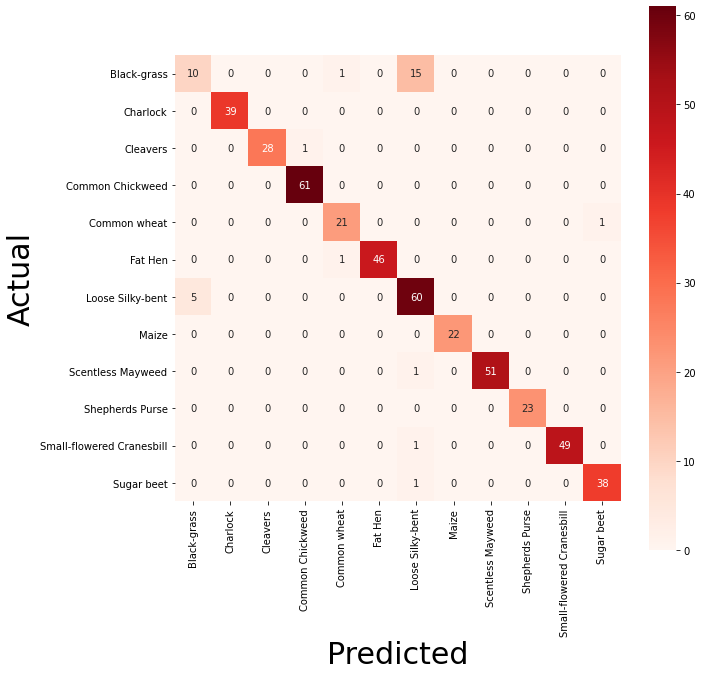

In [136]:
y_pred = final_model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, 
                 cmap=plt.cm.Reds, 
                 annot=True, 
                 square=True, 
                 xticklabels=species_list, 
                 yticklabels=species_list)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)